# Import package


In [1]:
import os
import requests
import autograd.numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize, Bounds
import datetime
from typing import List
from numba import njit
import warnings
import numpy.linalg as la
import time
from scipy.optimize import OptimizeResult

# Data import and processing


## Online


In [2]:
settledate = pd.to_datetime(datetime.date.today())
bonds = pd.DataFrame(
    json.loads(
        requests.get(
            "https://asx.api.markitdigital.com/asx-research/1.0/bonds/government/exchange-traded?height=179&width=690"
        ).content
    )["data"]["items"]
)
bonds["maturity"] = bonds["securityDescription"].str.extract(r"(\d{2}-\d{2}-\d{2})")[0]
bonds["maturity"] = pd.to_datetime(bonds["maturity"], format="%d-%m-%y")
bonds = bonds[["maturity", "couponPercent", "priceBid", "priceAsk"]]
bonds["couponPercent"] = bonds["couponPercent"].astype(float) / 100
bonds.dropna(inplace=True)
bonds.sort_values("maturity", inplace=True)
bonds.reset_index(drop=True, inplace=True)
bonds.to_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv", index=False)
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.100,101.20
1,2026-04-21,0.0425,101.000,104.00
2,2027-04-21,0.0475,102.750,103.32
3,2027-11-21,0.0275,98.530,98.77
4,2028-05-21,0.0225,96.730,96.99
5,2029-04-21,0.0325,98.850,99.60
6,2033-04-21,0.0450,103.000,104.50
7,2034-05-21,0.0375,96.600,98.00
8,2034-12-21,0.0350,92.700,96.83
9,2037-04-21,0.0375,94.350,95.80


## Offline


In [3]:
settledate = pd.to_datetime("2025-05-18")
bonds = pd.read_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv")
bonds["maturity"] = pd.to_datetime(bonds["maturity"])
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.00,99.95
1,2026-04-21,0.0425,100.81,103.00
2,2027-04-21,0.0475,102.10,103.32
3,2027-11-21,0.0275,97.50,98.22
4,2028-05-21,0.0225,96.00,96.37
5,2029-04-21,0.0325,97.00,99.82
6,2033-04-21,0.0450,101.65,103.50
7,2034-12-21,0.0350,92.70,96.83
8,2037-04-21,0.0375,93.00,93.30
9,2039-06-21,0.0325,85.75,92.00


# Support function


In [4]:
def year_transform(date: pd.Timestamp) -> float:
    """Transform date to actual year"""
    if date == settledate:
        return 0
    years = date.year - settledate.year
    check_date = pd.Timestamp(
        year=date.year,
        month=settledate.month,
        day=settledate.day,
    )
    years += (date - check_date).days / abs(
        (
            check_date
            + pd.DateOffset(years=np.sign((date - check_date).days))
            - check_date
        ).days
    )
    return years


def coupon_date_generate(maturity: pd.Timestamp) -> np.ndarray:
    """Generate coupon dates"""
    coupon_dates = [maturity]
    while maturity - pd.DateOffset(months=6) > settledate:
        maturity -= pd.DateOffset(months=6)
        coupon_dates.append(maturity)
    return np.array(list(map(year_transform, coupon_dates[::-1])))


def result_to_df(
    res: OptimizeResult, param_names: list[str] = None, df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Convert a scipy OptimizeResult into a pandas DataFrame row, appending to an existing df if provided.

    Parameters
    ----------
    res : OptimizeResult
        The result object returned by scipy.optimize.minimize (or similar).
    param_names : list of str, optional
        Names for the elements of res.x. If None, defaults to ['x0','x1',...].
    df : pandas.DataFrame, optional
        Existing DataFrame to which the new row will be appended. If None, a new DataFrame is created.

    Returns
    -------
    df_out : pandas.DataFrame
        DataFrame with the new result row added at the end.
    """
    # Ensure res.x is array
    x = np.atleast_1d(res.x)
    n = x.shape[0]
    # Determine param names
    if param_names is None:
        param_names = [f"f{i}" for i in range(n)]
        param_names[n - 1] = "gamma"
    elif len(param_names) != n:
        raise ValueError(f"param_names length {len(param_names)} != len(res.x) {n}")
    # Build row dict
    row = {name: float(val) for name, val in zip(param_names, x)}
    # Standard OptimizeResult attributes
    for attr in ("fun", "nit", "nfev", "njev", "status"):  # numeric
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    for attr in ("success", "message"):  # boolean or text
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    # Create or append to DataFrame
    row_df = pd.DataFrame([row])
    if df is None:
        return row_df
    else:
        # preserve column order: union of existing and new
        return pd.concat([df, row_df], ignore_index=True)

# Discount factor curve


In [5]:
def plot(params: np.ndarray, func: callable) -> None:
    t = np.linspace(0, 30, 100000)
    dfs = func(params, t)
    plt.figure(figsize=(15, 6))
    plt.plot(t, dfs)
    plt.title("Discount Factor Curve")
    plt.xlabel("Years")
    plt.ylabel("Discount Factor")
    plt.grid()
    plt.show()

# Basic functions


In [6]:
def discount_factor(params: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculate discount factor"""
    f0 = params[0]
    f1 = params[1]
    f2 = params[2]
    gamma = params[3]
    if gamma == 0:
        return np.exp(-f0 * t)
    if gamma < 0:
        raise ValueError("Gamma must be positive")
    res = -(
        f0 * t
        + f1 * (gamma - np.exp(-t / gamma) * gamma)
        + f2 * (gamma - np.exp(-t / gamma) * (t + gamma))
    )
    return np.exp(res)


def bond_valuation(params: np.ndarray, t: np.ndarray, coupon: float) -> float:
    """Calculate bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor(params, t))


def loss_function_component(
    params: np.ndarray, t: np.ndarray, coupon: float, bid: float, ask: float
) -> float:
    """Objective function for optimization"""
    bond_price = bond_valuation(params, t, coupon)
    if np.abs(bond_price) >= 1e154:
        return np.inf
    return (max(0, bond_price - ask) / ask) ** 2 + (max(0, bid - bond_price) / bid) ** 2

# Optimizing function


In [7]:
def constrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                params,
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

In [8]:
def unconstrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                np.array([params[0], params[1], params[2], np.exp(params[3])]),
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

## Library method for components


In [9]:
from autograd import grad, jacobian

jac_library = grad(constrained_target)
hess_library = jacobian(grad(constrained_target))

## Analytical method for components


In [10]:
from manual_grad.analytical_grad import loss_function_component_gradient_analytical
from manual_grad.analytical_grad import loss_function_component_hessian_analytical
import numpy as onp


def jac_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate jacobian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_analytical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate hessian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_analytical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

## Numerical method for components


In [11]:
from manual_grad.numerical_grad import loss_function_component_gradient_numerical
from manual_grad.numerical_grad import loss_function_component_hessian_numerical
import numpy as onp


def jac_numerical(params: np.ndarray, tolerance: float = 1e-5) -> np.ndarray:
    """Calculate jacobian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_numerical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_numerical(params: np.ndarray, tolerance: float = 1e-4) -> np.ndarray:
    """Calculate hessian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_numerical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

# Comparing gradient and hessian calulcating methods


## Gradient

### Speed

#### Library

In [12]:
%%timeit
jac_library(np.array([0.01, 0.01, 0.01, 0.01]))

38 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Analytical

In [13]:
%%timeit
jac_analytical(np.array([0.01, 0.01, 0.01, 0.01]))

110 ms ± 5.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Numerical

In [14]:
%%timeit
jac_numerical(np.array([0.01, 0.01, 0.01, 0.01]), tolerance=1e-5)

113 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Accuracy

#### Library agains analytical

In [15]:
error = []
for i in range(100):
    params = np.random.rand(4) * 0.1
    params[3] = np.exp(params[3])
    error.append(la.norm(jac_library(params) - jac_analytical(params)))
print("Mean error:", np.mean(error))
print("Standard deviation error", np.std(error))

Mean error: 1.4553526890624743e-14
Standard deviation error 2.2514528040671055e-14


#### Numerical agains analytical

In [16]:
error = []
for i in range(100):
    params = np.random.rand(4) * 0.1
    params[3] = np.exp(params[3])
    error.append(la.norm(jac_numerical(params, 1e-5) - jac_analytical(params)))
print("Mean error:", np.mean(error))
print("Standard deviation error", np.std(error))

Mean error: 4.0134779601915975e-06
Standard deviation error 5.474404051577837e-06


# Scipy Benchmarking

- Numpy has to be used for SciPy’s optimizers, imported as onp to avoid confusion


### Helper functions


In [17]:
from scipy.optimize import OptimizeResult


def result_to_df(
    res: OptimizeResult,
    param_names: list[str] = None,
    df: pd.DataFrame = None,
    type: str = "con",
) -> pd.DataFrame:
    """
    Convert a scipy OptimizeResult into a pandas DataFrame row, appending to an existing df if provided.

    Parameters
    ----------
    res : OptimizeResult
        The result object returned by scipy.optimize.minimize (or similar).
    param_names : list of str, optional
        Names for the elements of res.x. If None, defaults to ['x0','x1',...].
    df : pandas.DataFrame, optional
        Existing DataFrame to which the new row will be appended. If None, a new DataFrame is created.

    Returns
    -------
    df_out : pandas.DataFrame
        DataFrame with the new result row added at the end.
    """
    # Ensure res.x is array
    x = np.atleast_1d(res.x)
    n = x.shape[0]
    # Determine param names
    if param_names is None:
        param_names = [f"f{i}" for i in range(n)]
        param_names[n - 1] = "gamma"
    elif len(param_names) != n:
        raise ValueError(f"param_names length {len(param_names)} != len(res.x) {n}")
    # Build row dict
    row = {name: float(val) for name, val in zip(param_names, x)}
    row["x"] = x[3]
    row["gamma"] = np.exp(x[3]) if type == "uncon" else x[3]
    # Standard OptimizeResult attributes
    for attr in ("fun", "nit", "nfev", "njev", "status"):  # numeric
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    for attr in ("success", "message"):  # boolean or text
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    # Create or append to DataFrame
    row_df = pd.DataFrame([row])
    if df is None:
        return row_df
    else:
        # preserve column order: union of existing and new
        return pd.concat([df, row_df], ignore_index=True)


# Example usage:
# df = None
# df = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'], df=df)
# df = result_to_df(res_bfgs, param_names=['beta0','beta1','beta2','eta'], df=df)
# df['gamma'] = np.exp(df['eta'])
# print(df)
# df_pr = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'])
# df_pr['gamma'] = np.exp(df_pr['eta'])
# print(df_pr)

In [18]:
# recover the true gamma
def true_gamma(res):
    beta0, beta1, beta2, eta_opt = res.x
    gamma_opt = np.exp(eta_opt)
    print("Optimized NS params:", [beta0, beta1, beta2, gamma_opt])
    print("Final loss:", res.fun)

### Data Setup


In [19]:
import numpy as onp

# AUTOGRAD grad / hessian
grad_ag = grad(constrained_target)
hess_ag = hessian(constrained_target)

# Convert AUTOGRAD -> numpy
fun = lambda x: float(constrained_target(np.array(x)))
jac = lambda x: onp.array(grad(constrained_target)(np.array(x)))
hess = lambda x: onp.array(hessian(constrained_target)(np.array(x)))
hessp = lambda x, p: onp.array(hessian(constrained_target)(np.array(x)).dot(p))

# shared x0 + bounds
x0 = onp.array([0.042, -0.0318, -0.0268, 1.72])  # FOR BOTH CONSTRAINED & UNCON? 5,-1,1,1.5
bnds = [(-onp.inf, onp.inf)] * 3 + [(0, onp.inf)]
bobj = Bounds(*zip(*bnds))

In [20]:
# make autodiff versions
grad_uncon = grad(unconstrained_target)

# boundary lambdas that convert ArrayBox → float / ndarray
fun_uncon = lambda y: float(unconstrained_target(np.array(y)))
jac_uncon = lambda y: onp.array(grad_uncon(np.array(y)))
hessp_uncon = lambda x, p: onp.array(hessian(unconstrained_target)(np.array(x)).dot(p))

# initial guess + (no bounds on y, since gamma = exp(eta) is always >0)
y0 = onp.array([0.042, -0.0318, -0.0268, onp.log(1.72)])  # FOR UNCONSTRAINED

# Prepare a container for histories
histories = {}

### Conjugate Gradient (CG, Polak–Ribiere: variety of Fletcher–Reeves)


In [21]:
from optimize import davidon_fletcher_powell

In [22]:
losses_cg = []
times_cg = []
t0 = time.perf_counter()


def cb_cg(xk):
    # xk is the current iterate
    losses_cg.append(unconstrained_target(xk))
    times_cg.append(time.perf_counter() - t0)


# CG (Polak–Ribière nonlinear conjugate‐gradient algorithm (with occasional restarts))
res_pr = minimize(
    fun_uncon,
    y0,
    jac=grad_uncon,
    method="CG",
    callback=cb_cg,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["CG"] = {"loss": losses_cg, "time": times_cg}
res_pr

 message: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 1.6242330098562283e-05
       x: [ 5.732e-02 -1.902e-02 -1.924e-02  1.455e+00]
     nit: 300
     jac: [ 7.096e-06 -8.292e-06 -5.561e-06 -1.255e-05]
    nfev: 685
    njev: 683

In [23]:
print(true_gamma(res_pr))

Optimized NS params: [np.float64(0.05732493567126151), np.float64(-0.019024840862081827), np.float64(-0.019241017662708526), np.float64(4.285196911512179)]
Final loss: 1.6242330098562283e-05
None


In [24]:
performances = result_to_df(res_pr, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,0.057325,-0.019025,-0.019241,4.285197,1.455167,0.000016,300,685,683,1,False,Maximum number of iterations has been exceeded.


### Newton-CG & Trust-Region Newton


In [25]:
losses_ncg = []
times_ncg = []
t0 = time.perf_counter()


def cb_ncg(xk):
    losses_ncg.append(fun_uncon(xk))
    times_ncg.append(time.perf_counter() - t0)


res_newton = minimize(
    fun=fun_uncon,
    x0=y0,
    jac=jac_uncon,
    hessp=hessp_uncon,
    method="Newton-CG",
    callback=cb_ncg,
    options={"xtol": 1e-8, "maxiter": 300},
)

histories["Newton-CG"] = {"loss": losses_ncg, "time": times_ncg}

In [26]:
res_newton

 message: Warning: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 1.315277101470063e-05
       x: [ 6.568e-02 -2.840e-02 -5.199e-03  2.656e+00]
     nit: 300
     jac: [-1.139e-08 -6.125e-09  6.259e-08 -1.423e-07]
    nfev: 394
    njev: 394
    nhev: 1110

In [27]:
print("Newton-CG →", res_newton.x, res_newton.fun)
print(true_gamma(res_newton))


Newton-CG → [ 0.06567802 -0.02839633 -0.00519862  2.65565894] 1.315277101470063e-05
Optimized NS params: [np.float64(0.06567802278528798), np.float64(-0.028396328391774122), np.float64(-0.005198624166468562), np.float64(14.23436256068405)]
Final loss: 1.315277101470063e-05
None


In [28]:
performances = result_to_df(res_newton, df=performances, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,0.057325,-0.019025,-0.019241,4.285197,1.455167,0.000016,300,685,683,1,False,Maximum number of iterations has been exceeded.
1,0.065678,-0.028396,-0.005199,14.234363,2.655659,0.000013,300,394,394,1,False,Warning: Maximum number of iterations has been...


### L-BFGS-B


In [29]:
losses_lbfgsb = []
times_lbfgsb = []
t0 = time.perf_counter()


def cb_lbfgsb(xk):
    losses_lbfgsb.append(fun(xk))
    times_lbfgsb.append(time.perf_counter() - t0)


res_L_BFGS_B = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    bounds=bnds,
    method="L-BFGS-B",
    callback=cb_lbfgsb,
    options={"ftol": 1e-9, "maxiter": 300},
)
histories["L-BFGS-B"] = {"loss": losses_lbfgsb, "time": times_lbfgsb}
res_L_BFGS_B

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.32807120412248e-05
        x: [ 7.083e-02 -3.349e-02 -6.776e-03  1.701e+01]
      nit: 97
      jac: [ 2.191e-04  1.208e-04  5.528e-05 -1.160e-07]
     nfev: 122
     njev: 122
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [30]:
performances = result_to_df(res_L_BFGS_B, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,0.057325,-0.019025,-0.019241,4.285197,1.455167,0.000016,300,685,683,1,False,Maximum number of iterations has been exceeded.
1,0.065678,-0.028396,-0.005199,14.234363,2.655659,0.000013,300,394,394,1,False,Warning: Maximum number of iterations has been...
2,0.070830,-0.033492,-0.006776,17.005424,17.005424,0.000013,97,122,122,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


### BFGS


In [31]:
losses_bfgs = []
times_bfgs = []
t0 = time.perf_counter()


def cb_bfgs(y):
    losses_bfgs.append(fun_uncon(y))
    times_bfgs.append(time.perf_counter() - t0)


res_bfgs = minimize(
    fun=fun_uncon,
    x0=y0,
    jac=jac_uncon,
    method="BFGS",
    callback=cb_bfgs,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["BFGS"] = {"loss": losses_bfgs, "time": times_bfgs}
res_bfgs

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.3138695137498316e-05
        x: [ 6.641e-02 -2.912e-02 -3.819e-05  2.879e+00]
      nit: 86
      jac: [-5.268e-07 -1.432e-07 -2.573e-07  6.927e-09]
 hess_inv: [[ 2.813e+00 -2.429e+00 -2.998e-01  1.708e+02]
            [-2.429e+00  2.127e+00 -8.328e-01 -1.823e+02]
            [-2.998e-01 -8.328e-01  1.484e+03  5.093e+04]
            [ 1.708e+02 -1.823e+02  5.093e+04  1.760e+06]]
     nfev: 105
     njev: 105

In [32]:
true_gamma(res_bfgs)

Optimized NS params: [np.float64(0.06640524370818282), np.float64(-0.02912261279587322), np.float64(-3.8190793847606586e-05), np.float64(17.80350815343321)]
Final loss: 1.3138695137498316e-05


In [33]:
performances = result_to_df(res_bfgs, df=performances, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,0.057325,-0.019025,-0.019241,4.285197,1.455167,0.000016,300,685,683,1,False,Maximum number of iterations has been exceeded.
1,0.065678,-0.028396,-0.005199,14.234363,2.655659,0.000013,300,394,394,1,False,Warning: Maximum number of iterations has been...
2,0.070830,-0.033492,-0.006776,17.005424,17.005424,0.000013,97,122,122,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,0.066405,-0.029123,-0.000038,17.803508,2.879396,0.000013,86,105,105,0,True,Optimization terminated successfully.


# Manual implementation

In [34]:
from optimize import davidon_fletcher_powell, fletcher_reeves, gradient_projection, zoutendijk

In [35]:
losses = []
times = []
t0 = time.perf_counter()

def generic_callback(xk):
    # xk is the current iterate
    losses.append(unconstrained_target(xk))
    times.append(time.perf_counter() - t0)

res_dfp = davidon_fletcher_powell(
    fun_uncon,
    onp.array([5, -1, 0, onp.log(5)]),
    jac=grad_uncon,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["DFP"] = {"loss": losses, "time": times}

In [36]:
res_dfp

 message: Change of x is within tolerence
 success: True
  status: 0
     fun: 0.001017952264141673
       x: [ 8.713e-01 -8.289e-01 -7.960e-01  4.687e+00]
     nit: 44
    nfev: 317
    njev: 181
     jac: [ 1.511e+00  1.390e+00  1.126e-01 -1.620e-02]

In [37]:
performances = result_to_df(res_dfp, df=performances, type="uncon")
res_dfp

 message: Change of x is within tolerence
 success: True
  status: 0
     fun: 0.001017952264141673
       x: [ 8.713e-01 -8.289e-01 -7.960e-01  4.687e+00]
     nit: 44
    nfev: 317
    njev: 181
     jac: [ 1.511e+00  1.390e+00  1.126e-01 -1.620e-02]

In [38]:
losses = []
times = []
t0 = time.perf_counter()

res_fr = fletcher_reeves(
    fun_uncon,
    onp.array([0, 5, 0, onp.log(100)]),
    jac=grad_uncon,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["FR"] = {"loss": losses, "time": times}

c:\Users\leeha\UTS_PO_Assignment\optimize\fletcher_reeves.py:37: RuntimeWarning: Method BFGS cannot handle bounds.
  lsr = minimize(ls, [1], method="BFGS", bounds=[(0, None)])
c:\Users\leeha\UTS_PO_Assignment\optimize\fletcher_reeves.py:37: RuntimeWarning: Method BFGS cannot handle bounds.
  lsr = minimize(ls, [1], method="BFGS", bounds=[(0, None)])
c:\Users\leeha\AppData\Local\Programs\Python\Python312\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Users\leeha\AppData\Local\Programs\Python\Python312\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Users\leeha\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
c:\Users\leeha\AppData\Local\Programs\Python\Python312\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow enco

In [39]:
performances = result_to_df(res_fr, df=performances, type="uncon")
res_fr

 message: Norm of gradient is within tolerence
 success: True
  status: 0
     fun: 0.0
       x: [-1.145e+300 -1.165e+300  1.699e+298  3.840e+298]
     nit: 3
    nfev: 48
    njev: 26

In [40]:
losses = []
times = []
t0 = time.perf_counter()

res_gp = gradient_projection(
    fun,
    x0,
    jac=jac,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["grad_proj"] = {"loss": losses, "time": times}

In [41]:
performances = result_to_df(res_gp, df=performances)
res_gp

 message: Change of fun is within tolerence
 success: True
  status: 0
     fun: 0.000251502161335695
       x: [ 5.337e-02 -1.309e-02 -3.230e-02  1.721e+00]
     nit: 46
    nfev: 821
    njev: 434

In [42]:
import autograd.numpy as np
import numpy.linalg as la
from scipy.optimize import minimize, OptimizeResult, linprog


def zoutendijk(fun, x0, jac, callback, options: dict):
    A = np.array([[0, 0, 0, -1]])
    b = np.array([0])
    maxiter = options.get("maxiter", 100)
    tol = options.get("gtol", 1.0e-8)
    nit = 1
    nfev = 1
    njev = 1
    x_k = x0.copy()
    f_k = fun(x_k)
    g_k = jac(x_k)
    callback(x_k)

    res = OptimizeResult()
    if la.norm(g_k) < tol:
        res.x = x_k
        res.success = True
        res.status = 0
        res.message = "Norm of gradient is within tolerance"
        res.fun = f_k
        res.nit = 0
        res.nfev = nfev
        res.njev = njev
        res.jac = g_k
        return res

    while True:
        active_index = np.where(np.abs(A @ x_k - b) <= tol)[0]
        A_active = A[active_index, :] if active_index.size > 0 else None
        b_active = np.zeros(len(active_index)) if active_index.size > 0 else None

        linres = linprog(
            c=g_k,
            A_ub=A_active,
            b_ub=b_active,
            bounds=[(-1, 1)] * len(x_k),
            method="highs",
        )

        if not linres.success:
            res.x = x_k
            res.success = False
            res.status = 1
            res.message = "Linear subproblem failed"
            res.fun = f_k
            return res

        d_k = linres.x

        if np.abs(g_k.T @ d_k) <= tol:
            res.x = x_k
            res.success = True
            res.status = 0
            res.message = "Dot product of gradient and direction is within tolerance"
            res.fun = f_k
            res.nfev = nfev
            res.njev = njev
            res.nit = nit
            return res

        inactive_index = np.setdiff1d(np.arange(A.shape[0]), active_index)
        A_non_active = A[inactive_index, :] if inactive_index.size > 0 else np.empty((0, x_k.size))
        b_non_active = b[inactive_index] if inactive_index.size > 0 else np.empty((0,))

        RHS = b_non_active - A_non_active @ x_k
        LHS = A_non_active @ d_k
        bounds = [0, np.inf]
        for i in range(len(LHS)):
            if LHS[i] > 0:
                bounds[1] = min(bounds[1], RHS[i] / LHS[i])
            elif LHS[i] < 0:
                bounds[0] = max(bounds[0], RHS[i] / LHS[i])

        a_max = max(bounds[0], 0) if np.isfinite(bounds[1]) else 1.0

        ls = lambda alpha: fun(x_k + alpha[0] * d_k)
        lsr = minimize(ls, [1], method="L-BFGS-B", bounds=[(0, a_max)])
        alpha_k = lsr.x[0]
        nfev += lsr.nfev
        njev += lsr.njev

        x_k1 = x_k + alpha_k * d_k
        g_k1 = jac(x_k1)
        f_k1 = fun(x_k1)
        njev += 1
        nfev += 1
        callback(x_k1)

        if abs(alpha_k * la.norm(d_k)) < tol:
            res.x = x_k1
            res.success = True
            res.status = 0
            res.message = "Change in x is within tolerance"
            res.fun = f_k1
            res.nit = nit
            res.nfev = nfev
            res.njev = njev
            res.jac = g_k1
            return res

        if abs(f_k - f_k1) < tol:
            res.x = x_k1
            res.success = True
            res.status = 0
            res.message = "Change in objective is within tolerance"
            res.fun = f_k1
            res.nfev = nfev
            res.njev = njev
            res.nit = nit
            return res

        if la.norm(g_k1) < tol:
            res.x = x_k1
            res.success = True
            res.status = 0
            res.message = "Gradient norm is within tolerance"
            res.fun = f_k1
            res.nfev = nfev
            res.njev = njev
            res.nit = nit
            return res

        if nit >= maxiter:
            res.x = x_k1
            res.success = False
            res.status = 1
            res.message = "Maximum iterations reached"
            res.fun = f_k1
            res.nfev = nfev
            res.njev = njev
            res.nit = nit
            return res

        x_k = x_k1
        f_k = f_k1
        g_k = g_k1
        nit += 1


In [43]:
losses = []
times = []
t0 = time.perf_counter()

res_z = zoutendijk(
    fun,
    x0,
    jac=jac,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["zoutendijk"] = {"loss": losses, "time": times}
res_z

 message: Change in x is within tolerance
 success: True
  status: 0
     fun: 0.16859557202307288
       x: [ 4.200e-02 -3.180e-02 -2.680e-02  1.720e+00]
     nit: 1
    nfev: 3
    njev: 2
     jac: [-3.335e+01 -4.200e+00 -3.761e+00  1.155e-01]

In [44]:
performances = result_to_df(res_z, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,5.732494e-02,-1.902484e-02,-1.924102e-02,4.285197,1.455167e+00,0.000016,300,685,683,1,False,Maximum number of iterations has been exceeded.
1,6.567802e-02,-2.839633e-02,-5.198624e-03,14.234363,2.655659e+00,0.000013,300,394,394,1,False,Warning: Maximum number of iterations has been...
2,7.082960e-02,-3.349247e-02,-6.775728e-03,17.005424,1.700542e+01,0.000013,97,122,122,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,6.640524e-02,-2.912261e-02,-3.819079e-05,17.803508,2.879396e+00,0.000013,86,105,105,0,True,Optimization terminated successfully.
4,8.712891e-01,-8.288949e-01,-7.960334e-01,108.525968,4.686989e+00,0.001018,44,317,181,0,True,Change of x is within tolerence
5,-1.145026e+300,-1.164793e+300,1.698957e+298,inf,3.839981e+298,0.000000,3,48,26,0,True,Norm of gradient is within tolerence
6,5.336606e-02,-1.309149e-02,-3.229865e-02,1.720585,1.720585e+00,0.000252,46,821,434,0,True,Change of fun is within tolerence
7,4.200000e-02,-3.180000e-02,-2.680000e-02,1.720000,1.720000e+00,0.168596,1,3,2,0,True,Change in x is within tolerance


In [45]:
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,5.732494e-02,-1.902484e-02,-1.924102e-02,4.285197,1.455167e+00,0.000016,300,685,683,1,False,Maximum number of iterations has been exceeded.
1,6.567802e-02,-2.839633e-02,-5.198624e-03,14.234363,2.655659e+00,0.000013,300,394,394,1,False,Warning: Maximum number of iterations has been...
2,7.082960e-02,-3.349247e-02,-6.775728e-03,17.005424,1.700542e+01,0.000013,97,122,122,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,6.640524e-02,-2.912261e-02,-3.819079e-05,17.803508,2.879396e+00,0.000013,86,105,105,0,True,Optimization terminated successfully.
4,8.712891e-01,-8.288949e-01,-7.960334e-01,108.525968,4.686989e+00,0.001018,44,317,181,0,True,Change of x is within tolerence
5,-1.145026e+300,-1.164793e+300,1.698957e+298,inf,3.839981e+298,0.000000,3,48,26,0,True,Norm of gradient is within tolerence
6,5.336606e-02,-1.309149e-02,-3.229865e-02,1.720585,1.720585e+00,0.000252,46,821,434,0,True,Change of fun is within tolerence
7,4.200000e-02,-3.180000e-02,-2.680000e-02,1.720000,1.720000e+00,0.168596,1,3,2,0,True,Change in x is within tolerance


# View results

In [46]:
performances["algo"] = ["CG", "Newton-CG", "L-BFGS-B", "BFGS","DFP", "FR", "grad_proj", "zoutendijk"]
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message,algo
0,5.732494e-02,-1.902484e-02,-1.924102e-02,4.285197,1.455167e+00,0.000016,300,685,683,1,False,Maximum number of iterations has been exceeded.,CG
1,6.567802e-02,-2.839633e-02,-5.198624e-03,14.234363,2.655659e+00,0.000013,300,394,394,1,False,Warning: Maximum number of iterations has been...,Newton-CG
2,7.082960e-02,-3.349247e-02,-6.775728e-03,17.005424,1.700542e+01,0.000013,97,122,122,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,L-BFGS-B
3,6.640524e-02,-2.912261e-02,-3.819079e-05,17.803508,2.879396e+00,0.000013,86,105,105,0,True,Optimization terminated successfully.,BFGS
4,8.712891e-01,-8.288949e-01,-7.960334e-01,108.525968,4.686989e+00,0.001018,44,317,181,0,True,Change of x is within tolerence,DFP
5,-1.145026e+300,-1.164793e+300,1.698957e+298,inf,3.839981e+298,0.000000,3,48,26,0,True,Norm of gradient is within tolerence,FR
6,5.336606e-02,-1.309149e-02,-3.229865e-02,1.720585,1.720585e+00,0.000252,46,821,434,0,True,Change of fun is within tolerence,grad_proj
7,4.200000e-02,-3.180000e-02,-2.680000e-02,1.720000,1.720000e+00,0.168596,1,3,2,0,True,Change in x is within tolerance,zoutendijk


### Plot target func value over iterations and time

In [47]:
for name, h in histories.items():
    if "loss" in h:
        loss = onp.array(h["loss"])
        print(f"{name}: min={onp.nanmin(loss)}, max={onp.nanmax(loss)}")


CG: min=1.6242330098562283e-05, max=0.0009809980637917484
Newton-CG: min=1.315277101470063e-05, max=0.012539824173629512
L-BFGS-B: min=1.32807120412248e-05, max=0.0009904159371836479
BFGS: min=1.3138695137498316e-05, max=0.0009809980637917484
DFP: min=0.001017952264141673, max=12.478580803476078
FR: min=0.0, max=inf
grad_proj: min=0.02676629036290548, max=0.725742249213476
zoutendijk: min=0.725742249213476, max=0.725742249213476


In [48]:
if "FR" in histories:
    histories["Fletcher-Reeves"] = histories.pop("FR")


99th percentile loss: 0.8307046185910401


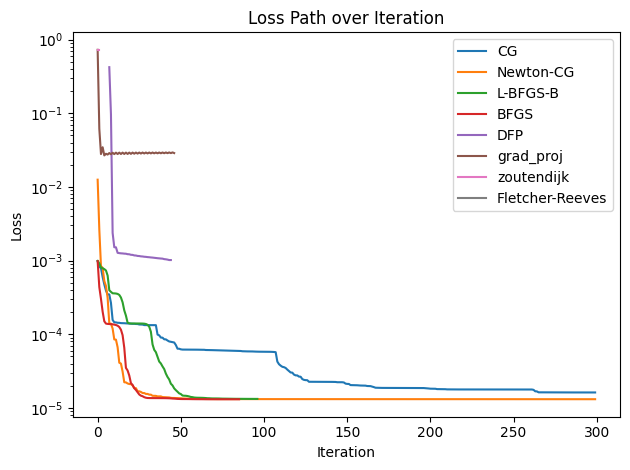

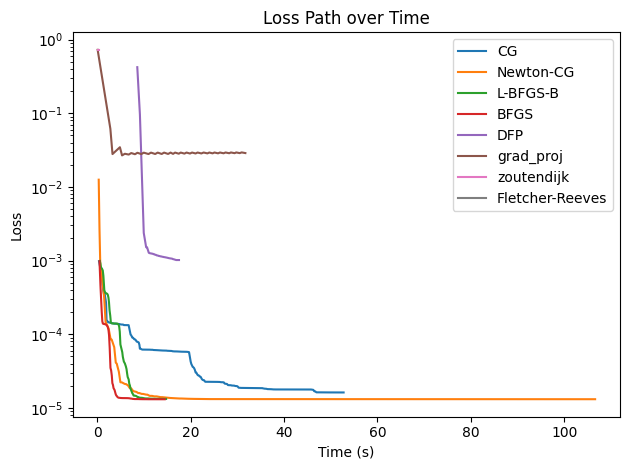

In [49]:
# stack and filter finite losses
all_losses = onp.hstack(
    [onp.array(h["loss"])[onp.isfinite(h["loss"])] for h in histories.values() if "loss" in h]
)

# high‐end cutoff (e.g. the 99th percentile)
cutoff = onp.percentile(all_losses, 99)
print("99th percentile loss:", cutoff)

plt.figure()
for name, h in histories.items():
    if "loss" in h:
        loss = onp.array(h["loss"])
        mask = onp.isfinite(loss) & (loss <= cutoff)
        plt.plot(onp.nonzero(mask)[0], loss[mask], label=name)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Path over Iteration")
plt.legend()
plt.tight_layout()
plt.savefig("loss_vs_iteration_clipped.pdf")
plt.show()

plt.figure()
for name, h in histories.items():
    if "loss" in h:
        loss = onp.array(h["loss"])
        time_steps = onp.array(h["time"])
        # same mask as before
        mask = onp.isfinite(loss) & (loss <= cutoff)
        # plot time_steps vs. loss
        plt.plot(time_steps[mask], loss[mask], label=name)
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.title("Loss Path over Time")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("loss_vs_time_clipped.pdf")
plt.show()

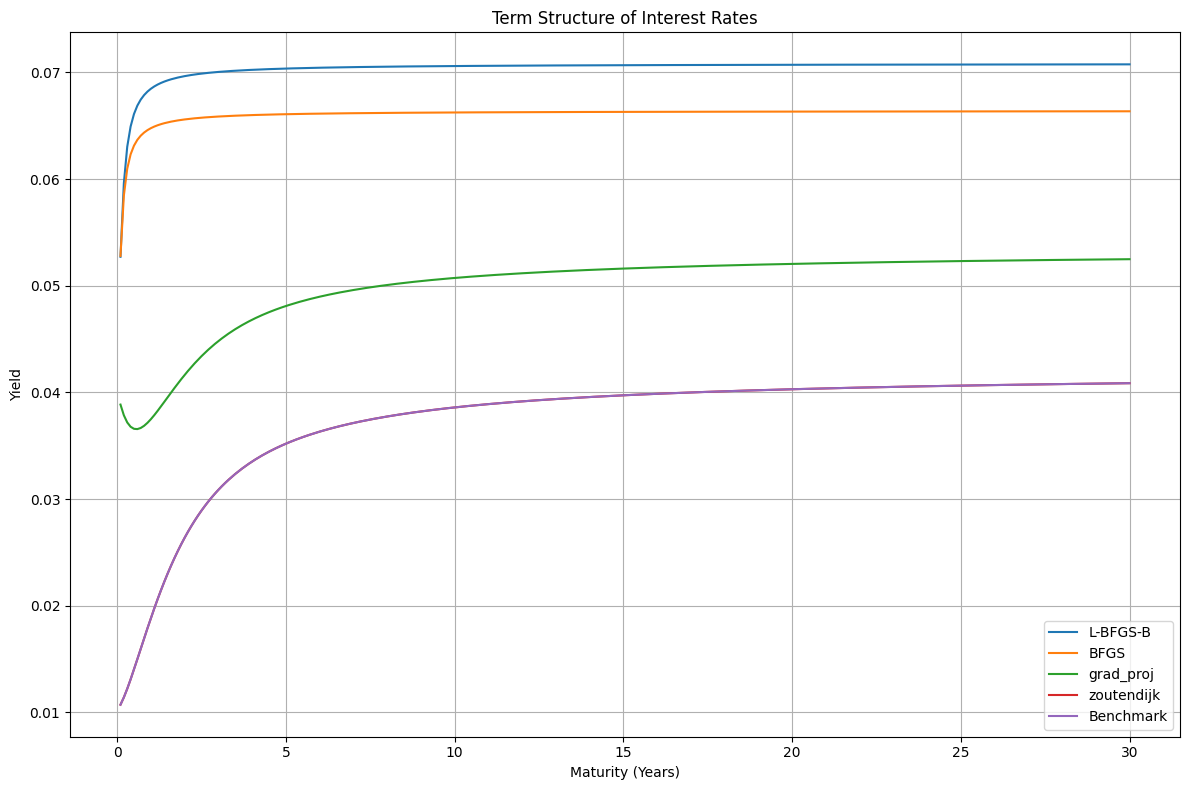

In [52]:
# Nelson-Siegel yield curve function
def nelson_siegel(tau, beta0, beta1, beta2, gamma):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-gamma * tau)) / (gamma * tau))
    term3 = beta2 * (((1 - np.exp(-gamma * tau)) / (gamma * tau)) - np.exp(-gamma * tau))
    return term1 + term2 + term3

required_columns = ["algo", "f0", "f1", "f2", "gamma"]
filtered_perf = performances[~performances['algo'].isin(['FR', 'DFP','CG','Newton-CG'])][required_columns]

benchmark_row = pd.DataFrame([{
    "algo": "Benchmark",
    "f0": 0.042,       # 4.20%
    "f1": -0.0318,     # -3.18%
    "f2": -0.0268,     # -2.68%
    "gamma": 1.72
}])

df = pd.concat([filtered_perf, benchmark_row], ignore_index=True)

# Time to maturity
tau = np.linspace(0.1, 30, 300)

# Plot term structures
plt.figure(figsize=(12, 8))
for _, row in df.iterrows():
    y = nelson_siegel(tau, row['f0'], row['f1'], row['f2'], row['gamma'])
    plt.plot(tau, y, label=row['algo'])

plt.title("Term Structure of Interest Rates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Property

In [53]:
def is_positive_semidefinite(H: np.ndarray) -> bool:
    eigenvalues = np.linalg.eigvalsh(H)
    return np.all(eigenvalues >= 0)


param_grid = [
    [f0, f1, f2, gamma]
    for f0 in np.linspace(-2, 2, 10)
    for f1 in np.linspace(-2, 2, 10)
    for f2 in np.linspace(-2, 2, 10)
    for gamma in np.linspace(1, 20, 10)
]

for params in param_grid:
    H = hess_analytical(params)
    if not is_positive_semidefinite(H):
        print("❌ Not PSD at:", params)

❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(1.0)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(3.111111111111111)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(5.222222222222222)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(7.333333333333334)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(9.444444444444445)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(11.555555555555555)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(13.666666666666668)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(15.777777777777779)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(17.88888888888889)]
❌ Not PSD at: [np.float64(-2.0), np.float64(-2.0), np.float64(-2.0), np.float64(20.0)]
❌ Not PSD at: [np.float6

In [54]:
initial_params = np.array([0.042,-0.0318,-0.0268,1.72])
target_grad = grad(unconstrained_target)

result = minimize(
    fun=unconstrained_target,
    x0=initial_params,
    method="BFGS",  # Quasi-Newton
    jac=grad_uncon,
    options={"disp": True},
)

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 105
         Function evaluations: 143
         Gradient evaluations: 143


In [55]:
print(result.success)
print(result.x)
print(result.fun)

True
[ 6.64049957e-02 -2.91224447e-02  1.28110524e-05  2.88112764e+00]
1.3138694835867808e-05


In [56]:
est_gamma = result.x[3]
est_f3 = result.x[2]
est_f3, est_gamma

(np.float64(1.2811052397092087e-05), np.float64(2.8811276352533164))

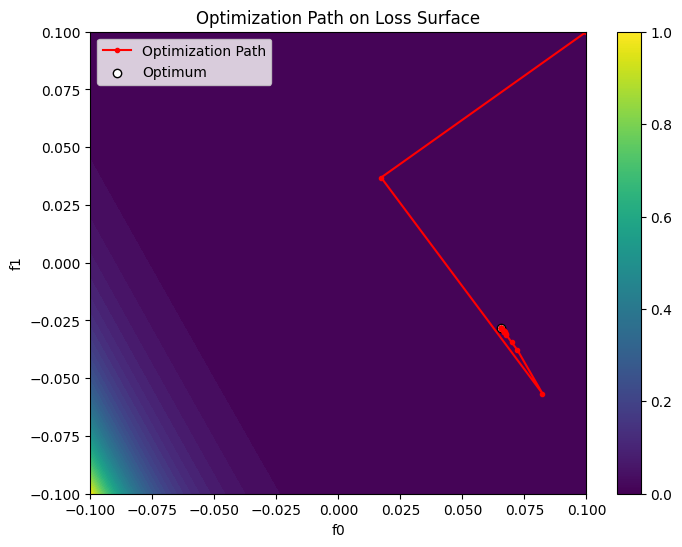

In [58]:
import autograd.numpy as np

f2_fixed = 0
gamma_fixed = 17
f0_vals = np.linspace(-0.1, 0.1, 100)
f1_vals = np.linspace(-0.1, 0.1, 100)
F0, F1 = np.meshgrid(f0_vals, f1_vals)
Z = np.zeros_like(F0)

for i in range(F0.shape[0]):

    for j in range(F0.shape[1]):

        params = np.array([F0[i, j], F1[i, j], f2_fixed, gamma_fixed])

        Z[i, j] = constrained_target(params)
def wrapped(params_2d):

    f0, f1 = params_2d

    return constrained_target(np.array([f0, f1, f2_fixed, gamma_fixed]))

grad_func = grad(wrapped)
start = np.array([0.1, 0.1])
trace = [start.copy()]
def callback(xk):

    trace.append(xk.copy())
res = minimize(wrapped, start, method="BFGS", jac=grad_func, callback=callback)
# 2d plot
trace = np.array(trace)
plt.figure(figsize=(8, 6))
plt.contourf(F0, F1, Z, levels=50, cmap="viridis")
plt.plot(trace[:, 0], trace[:, 1], "r.-", label="Optimization Path")
plt.scatter(res.x[0], res.x[1], color="white", edgecolor="black", label="Optimum")
plt.xlabel("f0")
plt.ylabel("f1")
plt.title("Optimization Path on Loss Surface")
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.legend()
plt.colorbar()
plt.show()

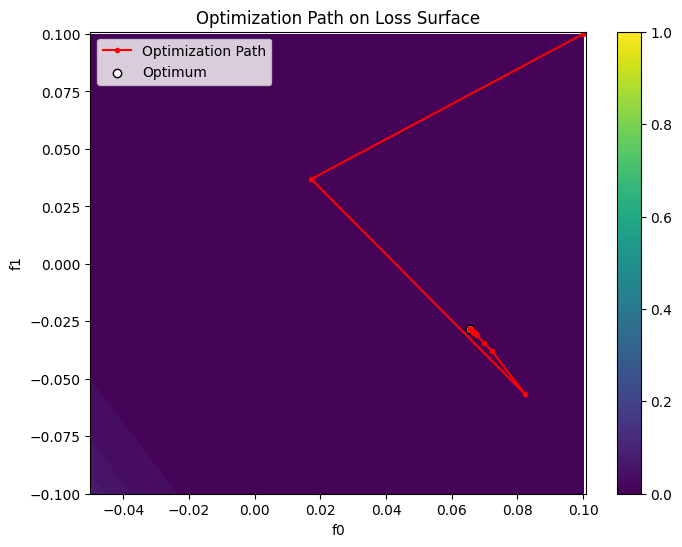

In [59]:
trace = np.array(trace)
plt.figure(figsize=(8, 6))
plt.contourf(F0, F1, Z, levels=50, cmap="viridis")
plt.plot(trace[:, 0], trace[:, 1], "r.-", label="Optimization Path")
plt.scatter(res.x[0], res.x[1], color="white", edgecolor="black", label="Optimum")
plt.xlabel("f0")
plt.ylabel("f1")
plt.title("Optimization Path on Loss Surface")
plt.xlim(-0.05, 0.101)
plt.ylim(-0.1, 0.101)
plt.legend()
plt.colorbar()
plt.show()

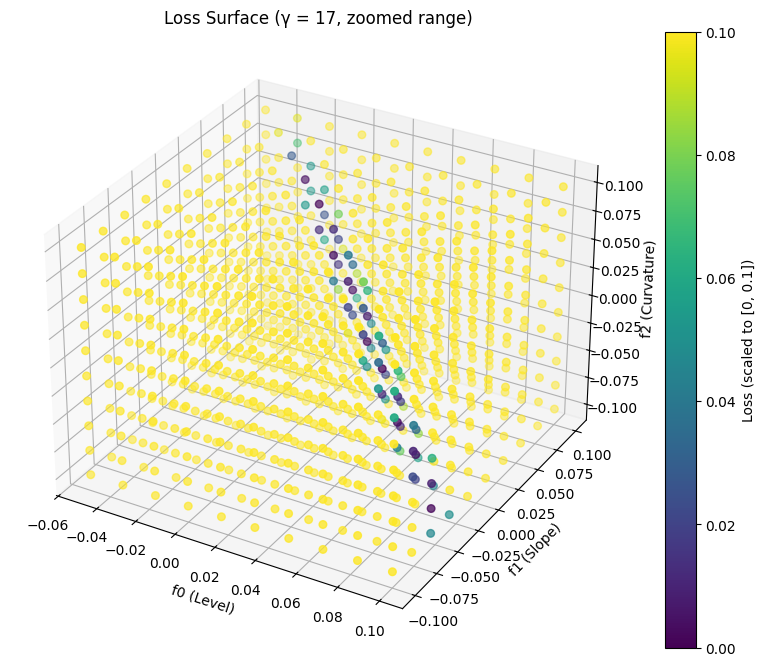

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

gamma_fixed = 17

f0_vals = np.linspace(-0.05, 0.1, 10)
f1_vals = np.linspace(-0.1, 0.1, 10)
f2_vals = np.linspace(-0.1, 0.1, 10)

f0_list = []
f1_list = []
f2_list = []
loss_list = []

for f0 in f0_vals:
    for f1 in f1_vals:
        for f2 in f2_vals:
            params = np.array([f0, f1, f2, gamma_fixed])
            loss = constrained_target(params)
            f0_list.append(f0)
            f1_list.append(f1)
            f2_list.append(f2)
            loss_list.append(loss)

f0_arr = np.array(f0_list)
f1_arr = np.array(f1_list)
f2_arr = np.array(f2_list)
loss_arr = np.array(loss_list)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    f0_arr, f1_arr, f2_arr, c=loss_arr, cmap="viridis", s=30, vmin=0.0, vmax=0.1
)

ax.set_xlabel("f0 (Level)")
ax.set_ylabel("f1 (Slope)")
ax.set_zlabel("f2 (Curvature)")
ax.set_title(f"Loss Surface (γ = {gamma_fixed}, zoomed range)")

cbar = plt.colorbar(sc, label="Loss")
cbar.ax.set_ylabel("Loss (scaled to [0, 0.1])")

plt.show()